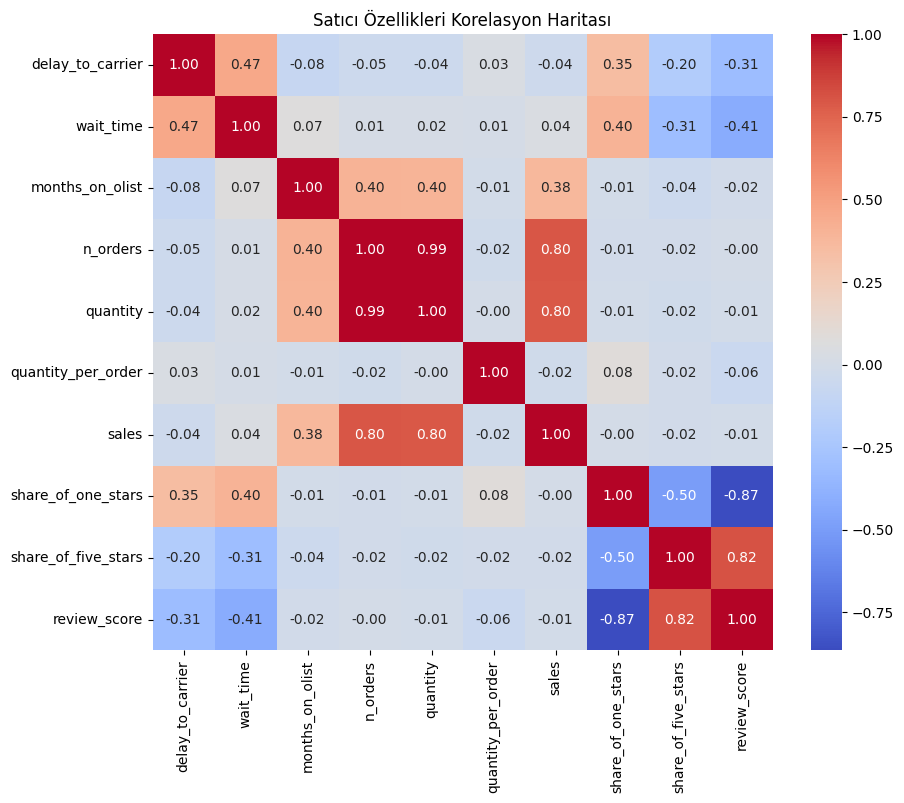

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from olist.seller import Seller
from olist.order import Order

# 1. Satıcı verilerini çekelim
sellers = Seller().get_training_data()

# 2. Korelasyon Matrisi
numeric_sellers = sellers.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_sellers.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Satıcı Özellikleri Korelasyon Haritası")
plt.show()

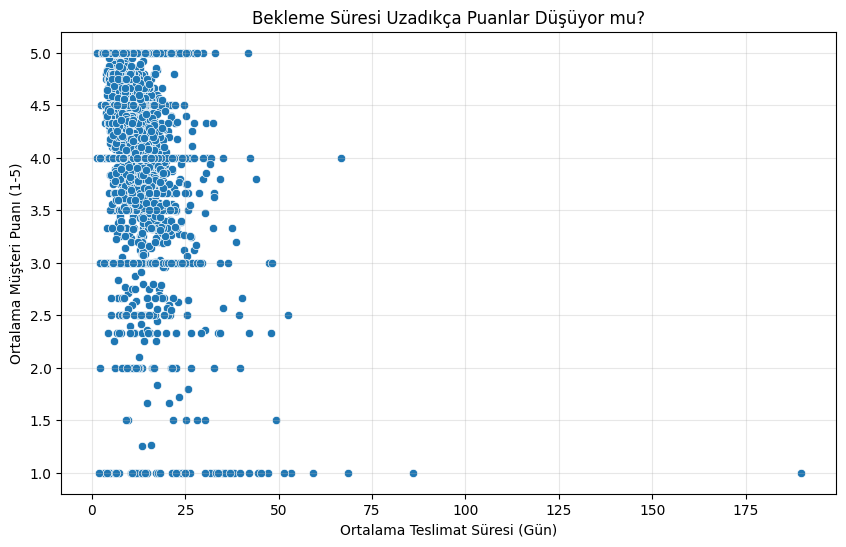

--- 🚨 Olist'in En Sorunlu 10 Satıcısı 🚨 ---
                             seller_id  share_of_one_stars  review_score  \
2742  1ca7077d890b907f89be8c954a02686a            0.535088      2.333333   
1355  b19f3ca2ea475913750f25a5c37c8d8f            0.458333      2.791667   
1407  54965bbe3e4f07ae045b90b0b8541f52            0.405405      3.000000   
1065  2eb70248d66e0e3ef83659f71b244378            0.402010      2.693467   
50    d71d863e5ef30d94e440c11be17dcd8f            0.384615      2.961538   
2271  dc8798cbf453b7e0f98745e396cc5616            0.357143      3.071429   
25    2a1348e9addc1af5aaa619b1a3679d6b            0.352941      3.117647   
1825  4c8b8048e33af2bf94f2eb547746a916            0.347826      2.956522   
2074  a49928bcdf77c55c6d6e05e09a9b4ca5            0.346939      3.010204   
1188  ad781527c93d00d89a11eecd9dcad7c1            0.340909      3.068182   

      wait_time  n_orders  
2742  15.028811       115  
1355  18.389999        24  
1407  26.727944        78  
1065  1

In [2]:
# 1. Grafik: Bekleme Süresi vs Müşteri Puanı
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wait_time', y='review_score', data=sellers)
plt.title("Bekleme Süresi Uzadıkça Puanlar Düşüyor mu?")
plt.xlabel("Ortalama Teslimat Süresi (Gün)")
plt.ylabel("Ortalama Müşteri Puanı (1-5)")
plt.grid(True, alpha=0.3)
plt.show()

# 2. "Kara Liste": En çok 1 yıldız alan satıcılar kimler?
# (Analizin güvenilir olması için en az 20 sipariş almış satıcılara bakıyoruz)
big_sellers = sellers[sellers['n_orders'] > 20]

# 1 yıldız oranı (share_of_one_stars) en yüksekten en düşüğe sırala
worst_sellers = big_sellers.sort_values(by='share_of_one_stars', ascending=False).head(10)

print("--- 🚨 Olist'in En Sorunlu 10 Satıcısı 🚨 ---")
# Görmek istediğimiz sütunları seçelim
print(worst_sellers[['seller_id', 'share_of_one_stars', 'review_score', 'wait_time', 'n_orders']])

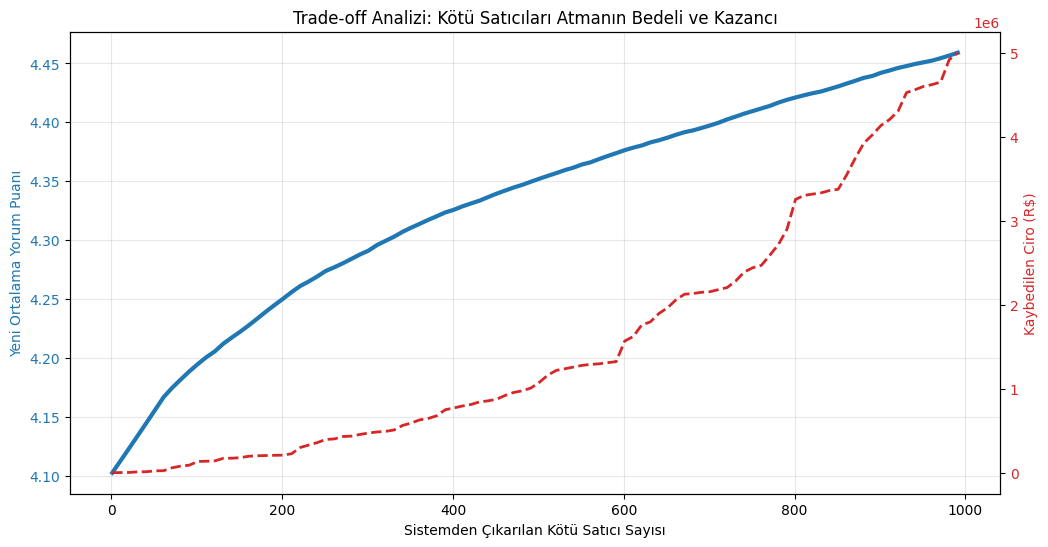

In [3]:
import numpy as np

# 1. Satıcıları "kötüden iyiye" doğru sıralayalım (1 yıldız oranına göre)
sellers_sorted = sellers.sort_values(by='share_of_one_stars', ascending=False)

# Toplam ciro ve toplam sipariş sayısı (Başlangıç durumu)
total_sales = sellers_sorted['sales'].sum()
avg_review_score = sellers_sorted['review_score'].mean() # Basit ortalama (Ağırlıklı da yapılabilir)

# Simülasyon sonuçlarını tutacağımız listeler
n_sellers_removed = []
revenue_loss = []
review_score_gain = []

# 2. Döngü: En kötü satıcıları tek tek sistemden atalım
# (Örnek olarak en kötü 1000 satıcıyı sırayla çıkarıp etkiye bakalım)
for i in range(1, 1000, 10): 
    # En kötü 'i' kadar satıcıyı çıkar
    remaining_sellers = sellers_sorted.iloc[i:]
    
    # Yeni metrikleri hesapla
    new_sales = remaining_sellers['sales'].sum()
    new_score = remaining_sellers['review_score'].mean()
    
    # Kaydedelim
    n_sellers_removed.append(i)
    revenue_loss.append(total_sales - new_sales) # Ne kadar ciro kaybettik?
    review_score_gain.append(new_score) # Yeni puanımız kaç oldu?

# 3. Grafiği Çizelim (İki eksenli grafik)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Sol Eksen: Yorum Puanı (Mavi Çizgi)
color = 'tab:blue'
ax1.set_xlabel('Sistemden Çıkarılan Kötü Satıcı Sayısı')
ax1.set_ylabel('Yeni Ortalama Yorum Puanı', color=color)
ax1.plot(n_sellers_removed, review_score_gain, color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Sağ Eksen: Ciro Kaybı (Kırmızı Çizgi)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Kaybedilen Ciro (R$)', color=color)
ax2.plot(n_sellers_removed, revenue_loss, color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Trade-off Analizi: Kötü Satıcıları Atmanın Bedeli ve Kazancı")
plt.show()